In [15]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Don't allow any numerical fault. More info: https://numpy.org/doc/stable/user/misc.html
np.seterr(all='raise')

mpl.rcParams["figure.figsize"] = (40, 5)

from typeguard import typechecked
from typing import cast

from numpy import datetime64
from numpy.typing import NDArray
from pandas import Timestamp, Timedelta
from pvlib import location
from pytz import timezone

from lib.utils import (
    get_irradiance,
    integrate,
    open_forecast_files,
    plot_radiation_and_irradiance,
    mae,
    rmse,
)
from lib.boat_model import Boat, Other
from lib.panel_model import Panel
from lib.battery_model import Battery
from lib.esc_model import ESC
from lib.motor_model import Motor
from lib.propulsion_model import Propulsion
from lib.hull_model import Hull
from lib.energy_controller_model import EnergyController, ConstantPowerController
from lib.boat_data import (
    BoatInputData,
    BoatInputDataSet,
    BoatOutputData,
)
from lib.event_model import Event, ControlledBoat
from lib.event_data import EventInputData, EventResultData, RaceStatus, FixedLapsGoal
from lib.competition_model import Competition

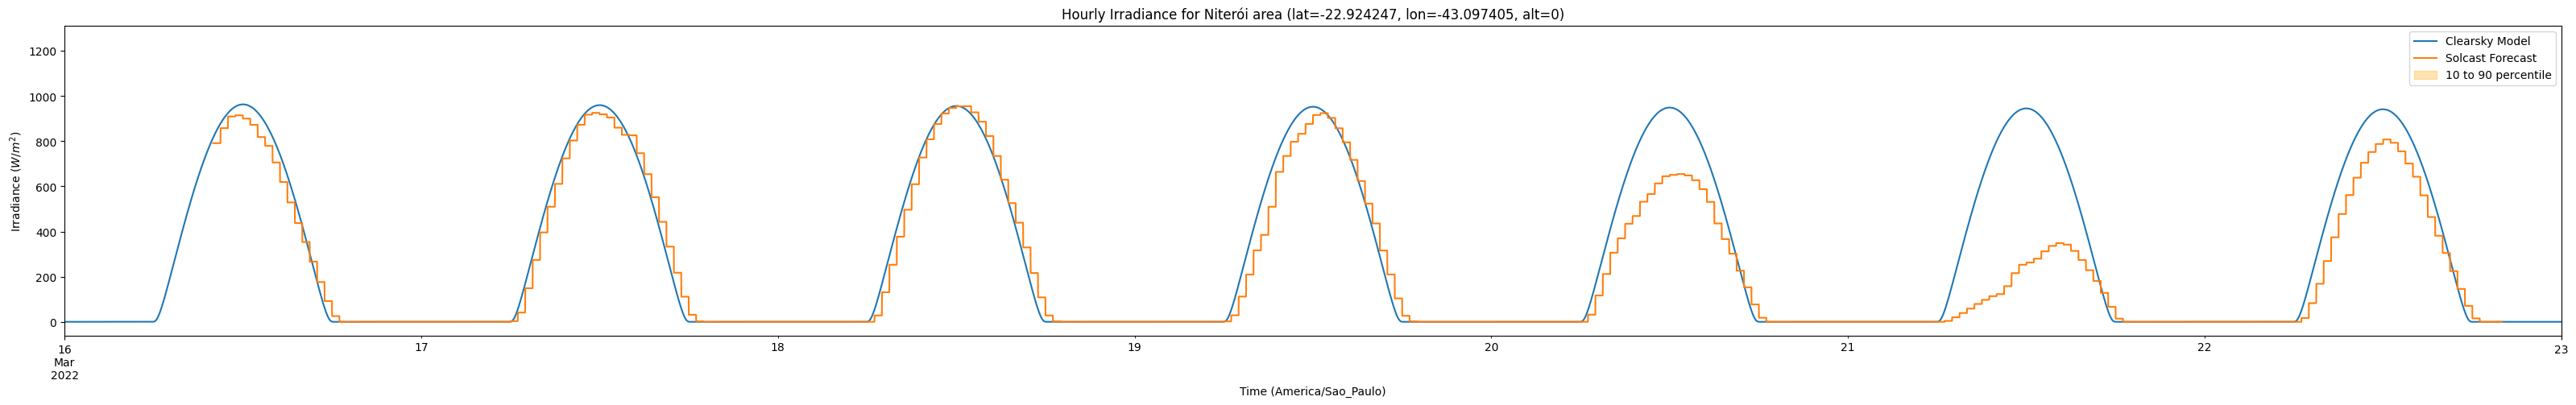

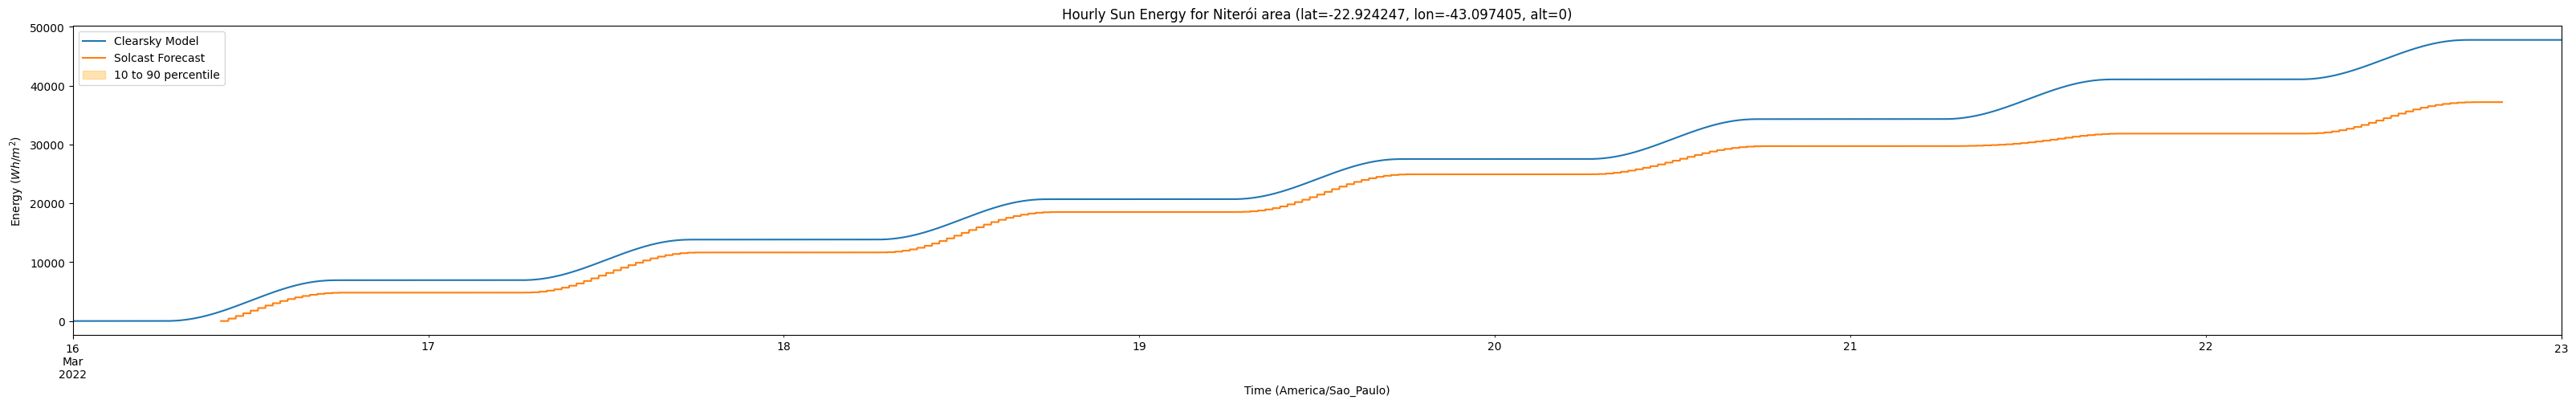

In [16]:
# Create the solar dataset
site = location.Location(
    latitude=-22.924247,
    longitude=-43.097405,
    tz="America/Sao_Paulo",
    altitude=0,
    name="Niterói",
)

description = {
    "time": {
        "start": "2022-03-16",
        "end": "2022-03-23",
        "freq": "1min",
    },
}

clearsky_data =  pd.DataFrame(site.get_clearsky(
    pd.date_range(
        start=description["time"]["start"],
        end=description["time"]["end"],
        freq=description["time"]["freq"],
        tz=site.tz,
    )
))

clearsky_data["poa"] = get_irradiance(
    site_location=site,
    tilt=0,
    surface_azimuth=0,
    weather_data=clearsky_data,
)

clearsky_data = clearsky_data[description["time"]["start"] : description["time"]["end"]]

clearsky_data["Solar Energy"] = integrate(clearsky_data, 3600)["poa"]

path = "/home/joaoantoniocardoso/ZeniteSolar/2022/Strategy22"

forecast_files = [
    # f"{path}/datasets/solcast_forecast_14032022_1955.csv",
    f"{path}/datasets/solcast_forecast_16032022_0947.csv",
    f"{path}/datasets/solcast_forecast_17032022_0522.csv",
    f"{path}/datasets/solcast_forecast_17032022_0948.csv",
    f"{path}/datasets/solcast_forecast_17032022_1338.csv",
    f"{path}/datasets/solcast_forecast_17032022_1519.csv",
    f"{path}/datasets/solcast_forecast_18032022_0916.csv",
    f"{path}/datasets/solcast_forecast_18032022_1208.csv",
    f"{path}/datasets/solcast_forecast_18032022_1535.csv",
    f"{path}/datasets/solcast_forecast_19032022_0141.csv",
    f"{path}/datasets/solcast_forecast_19032022_0554.csv",
    f"{path}/datasets/solcast_forecast_19032022_0906.csv",
    f"{path}/datasets/solcast_forecast_19032022_1555.csv",
    f"{path}/datasets/solcast_forecast_20032022_0618.csv",
    f"{path}/datasets/solcast_forecast_20032022_1300.csv",
    f"{path}/datasets/solcast_forecast_21032022_0057.csv",
    f"{path}/datasets/solcast_forecast_21032022_1901.csv",
]

real_data = open_forecast_files(forecast_files, description)

real_data.drop(columns=["Period"], inplace=True)
real_data.columns = real_data.columns.str.lower()
real_data.rename(
    columns={"cloudopacity": "Cloud Opacity", "airtemp": "Air Temp"}, inplace=True
)
real_data.index = pd.to_datetime(real_data.index).tz_convert(site.tz)  # type: ignore
freq = pd.infer_freq(real_data.index)
if freq is None:
    raise Exception("Failed infering frequency!")
real_data.index.freq = freq  # type: ignore
real_data10 = real_data[["ghi10", "dni10", "dhi"]].rename(
    columns={"ghi10": "ghi", "dni10": "dni"}
)
real_data90 = real_data[["ghi90", "dni90", "dhi"]].rename(
    columns={"ghi90": "ghi", "dni90": "dni"}
)

real_data["poa"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data
)
real_data["poa10"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data10
)
real_data["poa90"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data90
)

real_data = real_data[description["time"]["start"] : description["time"]["end"]]

real_data["Solar Energy"] = integrate(real_data, 3600)["poa"]
real_data["Solar Energy10"] = integrate(real_data, 3600)["poa10"]
real_data["Solar Energy90"] = integrate(real_data, 3600)["poa90"]

real_data = real_data.resample("10s").ffill()

plot_radiation_and_irradiance(clearsky_data, real_data, site)



In [17]:
# Select the input data
from dataclasses import dataclass


input_data = BoatInputDataSet(
    {
        "time": pd.DatetimeIndex(real_data.index).tz_convert(None).to_numpy(),
        "poa": real_data["poa"].to_numpy(),
    }
)


In [18]:
# Create the competition
tzinfo = timezone(site.tz)
competition = Competition(
    name="DSB 2022 - Etapa Niterói",
    events=[
        Event(
            EventInputData(
                name="Match Race Qualifiers",
                description="Classificatórias da prova 1x1",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=np.float64(786.73),
                    event_duration=Timedelta(hours=1),
                ),
                start=Timestamp(year=2022, month=3, day=17, hour=9, minute=30, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=17, hour=10, minute=30, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Match Race",
                description="Prova 1x1",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=np.float64(786.73),
                    event_duration=Timedelta(hours=2),
                ),
                start=Timestamp(year=2022, month=3, day=17, hour=14, minute=00, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=17, hour=16, minute=00, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Long Race 1",
                description="Prova longa",
                goal=FixedLapsGoal(
                    total_laps=3*2,
                    lap_distance=np.float64(7081.987),
                    event_duration=Timedelta(hours=5),
                ),
                start=Timestamp(year=2022, month=3, day=18, hour=11, minute=00, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=18, hour=16, minute=00, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Relay Race",
                description="Prova de revezamento de pilotos",
                goal=FixedLapsGoal(
                    total_laps=2,
                    lap_distance=np.float64(812.19),
                    event_duration=Timedelta(hours=3),
                ),
                start=Timestamp(year=2022, month=3, day=19, hour=9, minute=30, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=19, hour=12, minute=30, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Short Race 1",
                description="Prova curta",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=np.float64(4678.39),
                    event_duration=Timedelta(hours=2),
                ),
                start=Timestamp(year=2022, month=3, day=20, hour=11, minute=30, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=20, hour=13, minute=30, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Quick Race 1",
                description="Prova rápida",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=np.float64(4678.39),
                    event_duration=Timedelta(hours=1),
                ),
                start=Timestamp(year=2022, month=3, day=20, hour=9, minute=30, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=20, hour=10, minute=30, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Sprint Race",
                description="Prova de arrancada",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=np.float64(1057.03),
                    event_duration=Timedelta(hours=15),
                ),
                start=Timestamp(year=2022, month=3, day=22, hour=10, minute=30, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=22, hour=12, minute=00, tzinfo=tzinfo).tz_convert(None),
            )
        ),
    ],
)


from strictly_typed_pandas.dataset import DataSet


@dataclass
class PredictionData:
    time: datetime64
    poa: np.float64
    poa10: np.float64
    poa90: np.float64


PredictionDataSet = DataSet[PredictionData]


In [19]:
# Create the energy controller
from scipy.optimize import least_squares, OptimizeResult

def create_boat():
    return Boat(
        name="Zenite Solar",
        panel=Panel(efficiency=np.float64(0.16), maximum_output_power=np.float64(4 * 300), area=np.float64(4 * 1.6 * 1.0)),
        battery=Battery(
            efficiency=np.float64(0.8),
            soc_0=np.float64(0.95),
            minimum_soc=np.float64(0.25),
            maximum_energy=np.float64(1500),
            maximum_power=np.float64(10000),
        ),
        circuits=Other(power=np.float64(18 * 3.0)),
        esc=ESC(
            efficiency=np.float64(0.85),
            maximum_input_power=np.float64(5000),
        ),
        motor=Motor(efficiency=np.float64(0.85), maximum_input_power=np.float64(150.0*36.0)),
        propulsion=Propulsion(
            efficiency=np.float64(0.7),
            maximum_input_power=np.float64(10000),
        ),
        hull=Hull(speed_over_power_constant=np.float64(0.097), exponential_factor=np.float64(0.584)),
    )

# Create the boat
boat = create_boat()

# Create the energy controller
class AverageController(EnergyController):
    @typechecked
    def __init__(self, prediction_dataset: PredictionDataSet, overdrive: np.float64):
        self.overdrive: np.float64 = overdrive
        self.prediction_dataset: PredictionDataSet = prediction_dataset
        self.event_power: np.float64 = np.float64(0.0)
        self.event_name: str = ""
        self.throttle: np.float64 = np.float64(0.0)
        # self.competition_poa_avg: np.float64 = np.float64(0.0)
        # self.competition_energy: np.float64 = np.float64(0.0)

    @typechecked
    def before_event_start(
        self,
        boat: Boat,
        event: EventInputData,
    ) -> None:
        self.event_name = event.name
        self.event_battery_energy = boat.battery.energy - boat.battery.minimum_energy
        # self.competition_poa_avg = np.float64(0.0)
        # self.competition_energy = np.float64(0.0)

    def solve_time(self, event: EventInputData, soc_target: np.float64) -> np.float64:

        debug_solver = False
        solver_data = {
            "uncompleted_event_penalty" : [],
            "undeliver_power" : [],
            "soc_end" : [],
            "soc_error" : [],
            "traveled_distance": [],
            "t_i" : [],
            "throttle" : [],
            "loss" : []
        }

        event_start = event.start
        event_duration = (event.end - event.start).to_numpy().astype(np.float64) * np.float64(1e-9 / 3600)

        def fun(x: NDArray[np.float64]) -> NDArray[np.float64]:
            t_i = np.float64(x[0])
            throttle_i = np.float64(x[1])

            event_end = event_start + pd.Timedelta(hours=t_i)
            pred_event_df = self.pred_competition_df.query('time >= @event_start & time <= @event_end')

            this_boat = create_boat()

            soc_start = this_boat.battery.soc = boat.battery.soc
            soc_min = soc_target
            target_delta_soc = soc_start - soc_min

            results = this_boat.solve(t_i * 3600, pred_event_df.mean()["poa"], throttle_i)
            soc_end = results.battery_soc
            delta_soc = soc_start - soc_end

            event_goal = cast(FixedLapsGoal, event.goal)
            event_distance = event_goal.total_laps * event_goal.lap_distance
            traveled_distance = results.hull_speed * (t_i * 3600)

            uncompleted_event_penalty = rmse(event_distance, traveled_distance)
            undeliver_power = rmse(results.battery_target_power, results.battery_output_power)
            soc_error = mae(target_delta_soc, delta_soc) if (delta_soc < target_delta_soc) else np.float64(0.0)

            loss = soc_error + undeliver_power + uncompleted_event_penalty

            if debug_solver:
                solver_data["uncompleted_event_penalty"].append(uncompleted_event_penalty)
                solver_data["undeliver_power"].append(undeliver_power)
                solver_data["soc_end"].append(soc_end)
                solver_data["traveled_distance"].append(traveled_distance)
                solver_data["soc_error"].append(soc_error)
                solver_data["loss"].append(loss)
                solver_data["t_i"].append(t_i)
                solver_data["throttle"].append(throttle_i)

            return np.array([soc_error, undeliver_power, uncompleted_event_penalty], dtype=np.float64)

        res: OptimizeResult = least_squares(fun, x0=[0.5 * event_duration, 0.5], bounds=[(0.01, 0.01), (event_duration, 1.0)])
        if res.success == 0:
            print(f'Failed to solve fot time: {res.message}')


        if debug_solver:
            print(res)

            fig, axs = plt.subplots(2, figsize=(10, 2 * 2.0), sharex=True, sharey=False)
            axs[0].plot(solver_data["soc_error"], label="soc_error")
            axs[0].plot(solver_data["uncompleted_event_penalty"], label="uncompleted_event_penalty")
            axs[0].plot(solver_data["undeliver_power"], label="undeliver_power")
            axs[0].plot(np.array(solver_data["loss"])/3, label="loss")
            axs[0].legend(loc="upper right")

            axs[1].plot(solver_data["t_i"], label="t_i")
            axs[1].plot(solver_data["throttle"], label="throttle")
            axs[1].legend(loc="upper right")

            print(f"{solver_data['uncompleted_event_penalty'][-1]=}")
            print(f"{solver_data['undeliver_power'][-1]=}")
            print(f"{solver_data['soc_error'][-1]=}")
            print(f"{solver_data['loss'][-1]=}")
            print(f"{solver_data['t_i'][-1]=}")
            print(f"{solver_data['throttle'][-1]=}")
            print(f"{solver_data['traveled_distance'][-1]=}")
            print(f"{solver_data['soc_end'][-1]=}")

            plt.show()
            ax = plt.figure().add_subplot(projection='3d')
            ax.scatter(np.array(solver_data["throttle"]), np.array(solver_data["t_i"]), np.array(solver_data["soc_error"]), label="soc_error")


        return np.float64(res.x[1])

    @typechecked
    def solve(
        self,
        dt: np.float64,
        k: int,
        input_data: BoatInputData,
        output_data: BoatOutputData,
        event_result: EventResultData,
        boat: Boat,
        event: EventInputData,
    ) -> np.float64:
        """
        1. get current input power
        2. get total the race energy
        3. get the race duration
        4. compute the average power for the race by diving the total race energy by its duration
        5. compute the average power drawn from the battery to finish the race within its duration
        6. compute the output power by summing battery and panel
        7. compute the percentage throttle from the motor model, `P = dt^2 / R`
        input_power = output_power / boat.motor.efficiency

        D = V * t
        E = P * t
        P = C_f * V**a
        V = (E / (D * C_f))**(1/2)
        D = (E * t**2 / C_f)**(1/3)
        t = (C_f * D**a / E)**(1/2)

        t(E,V)

        D = V * t
        E = P * t

        Strategy: 
        - Compute the target output energy we have to spend in the race
        - Compute the time it would take to finish the race with the given output energy

        First, for a given Energy and Distance, the required time would be:
        t = (C_f * D**a / E)**(1/2)

        The available energy is the sum of the battery energy with the solar energy:
            E = E_b + E_pv
        But the solar energy depends on time, like:
            E = E_b + Integral of P dt

        So it might be easier to move from energy to time:
            E = Integral of P dt
            E = Integral of (P_b + Ppv) dt

            t = (C_f * D**a / E)**(1/2)
            t * (E)**(1/2) = (C_f * D**a)**(1/2)
            t * (Integral of P(t) dt)**(1/2) = (C_f * D**a)**(1/2)

            A = C_f * D**a
            t**2 * (Integral of P(t) dt) -A = 0

            ..one solution is to derive it in regard of time:
            ( t * P(t) + 2*(Integral of P(t) dt) ) / ( 2 * ((Integral of P(t) dt))**(1/2) ) = 0

            (t * P(t) + 2*(Integral of P(t) dt)) = 0 -> to zero
            derivating it again:
            t = 3 * P(t) / ( d(P(t))/dt )

            t * d(P(t))/dt - 3 * P(t) = 0
            P(t) = t * d(P(t))/dt / 3  -> D'Alembert's equation  /  Lagrange's equation

            This is a first-order nonlinear ODE with a known solution:
            P(t) = c * t**3
            so:
            t = c * P(t)**(1/3)
                ..and maybe, c = (C_f * D**a)**(1/2)
            
            c = t / P(t)**(1/3)
                for t == 0:

            t = (C_f * D**a / E)**(1/2)
            t = (C_f * D**a / (P_b*t + P_pv*t))**(1/2)
            t**2 = C_f * D**a / (P_b*t + P_pv*t)
            t**2 = C_f * D**a / (t * (P_b + P_pv))
            t**3 = C_f * D**a / (P_b + P_pv)
            t = ((C_f * D**a) / (P_b + P_pv))**(1/3)


        t = ((C_f * D**a) / (P_b + P_pv))**(1/3)


        ~We can first reserve the necessary time to recharge the battery after we finish it~

        """

        if k == 0:
            self.pred_competition_df = self.prediction_dataset.to_dataframe().set_index(
                "time"
            )
            self.throttle = self.solve_time(event, soc_target=np.float64(0.3))

        elif event_result.status != RaceStatus.STARTED:
            return np.float64(0.0)

        """
        D = V * t
        E = P * t
        V(P)

        P = E / t

        D = V * t
        D = V(P) * t
        D = V(E / t) * t
        t = D / V(E / t)
        """

        # pred_poa: np.float64 = (
        #     self.prediction_dataset.to_dataframe().set_index("time")["poa"].iloc[k]
        # )

        return self.throttle

predicition_dataset = PredictionDataSet(
    {
        "time": pd.DatetimeIndex(real_data.index).tz_convert(None).to_numpy(),
        "poa": real_data.poa.to_numpy(),
        "poa10": real_data.poa10.to_numpy(),
        "poa90": real_data.poa90.to_numpy(),
    }
)

energy_controller = AverageController(
    prediction_dataset=predicition_dataset,
    overdrive=np.float64(1.0),
)


In [20]:
# Run the simulation. Note that the output is timezone-naive, .tz_convert() needs to be used before post-processing/plotting
competition_result = competition.solve(
    input_data=input_data, controlled_boats=[ControlledBoat(boat=boat, energy_controller=energy_controller), ControlledBoat(boat=boat, energy_controller=ConstantPowerController(constant=np.float64(0.3)))]
)

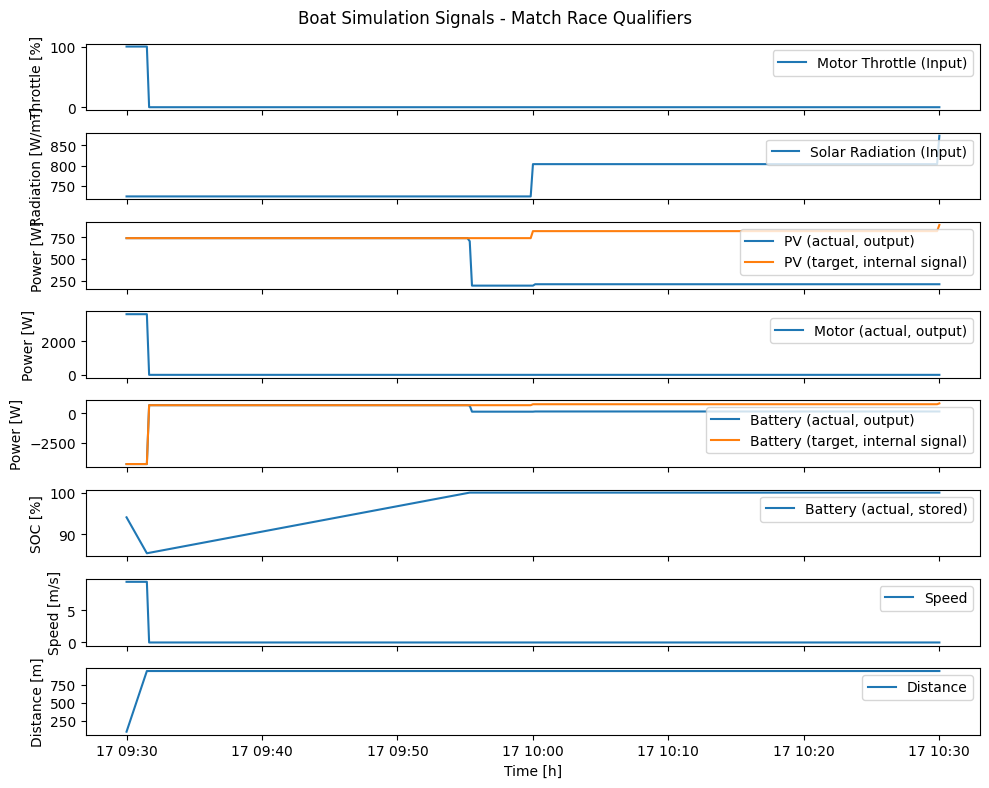

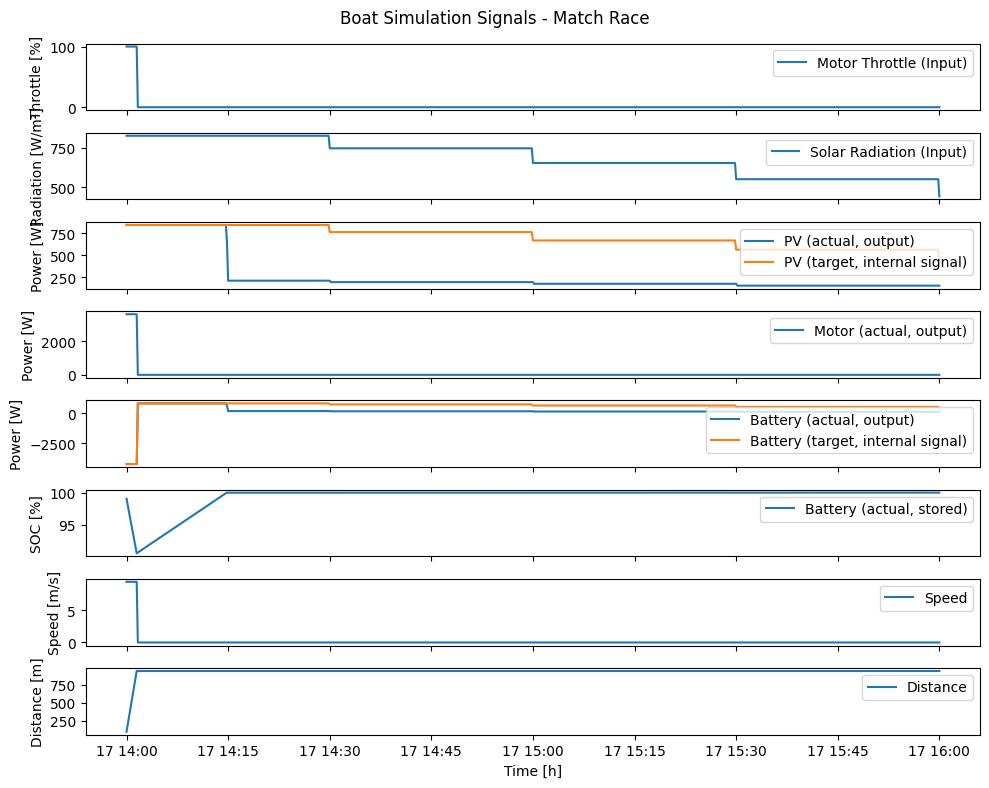

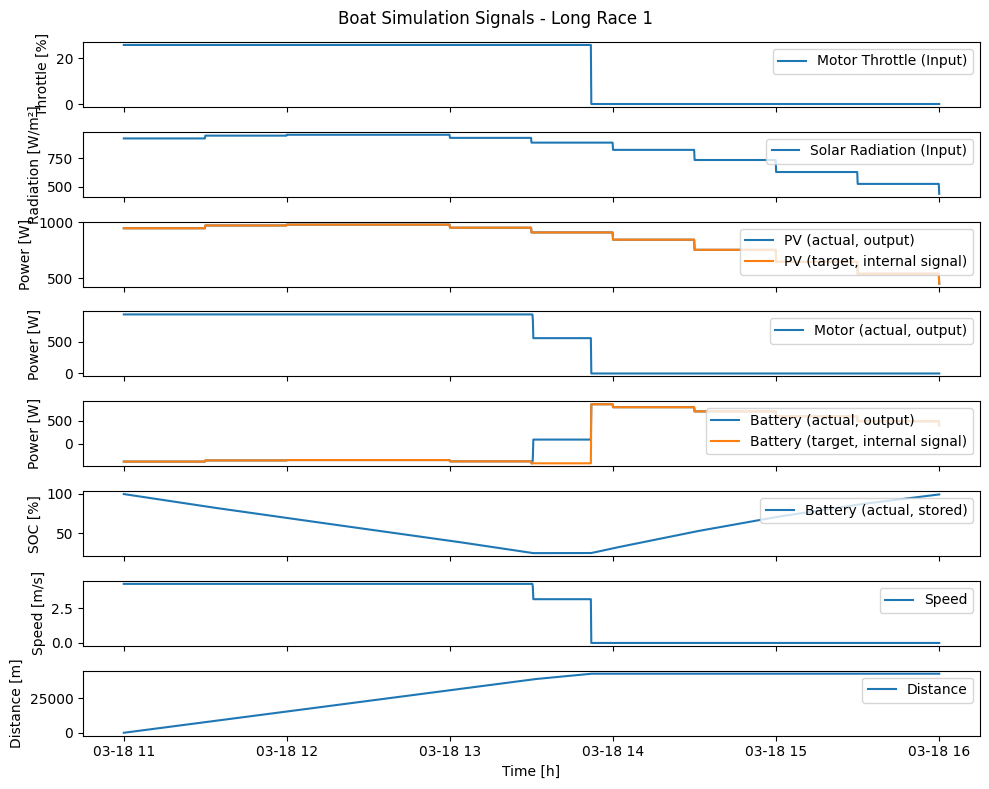

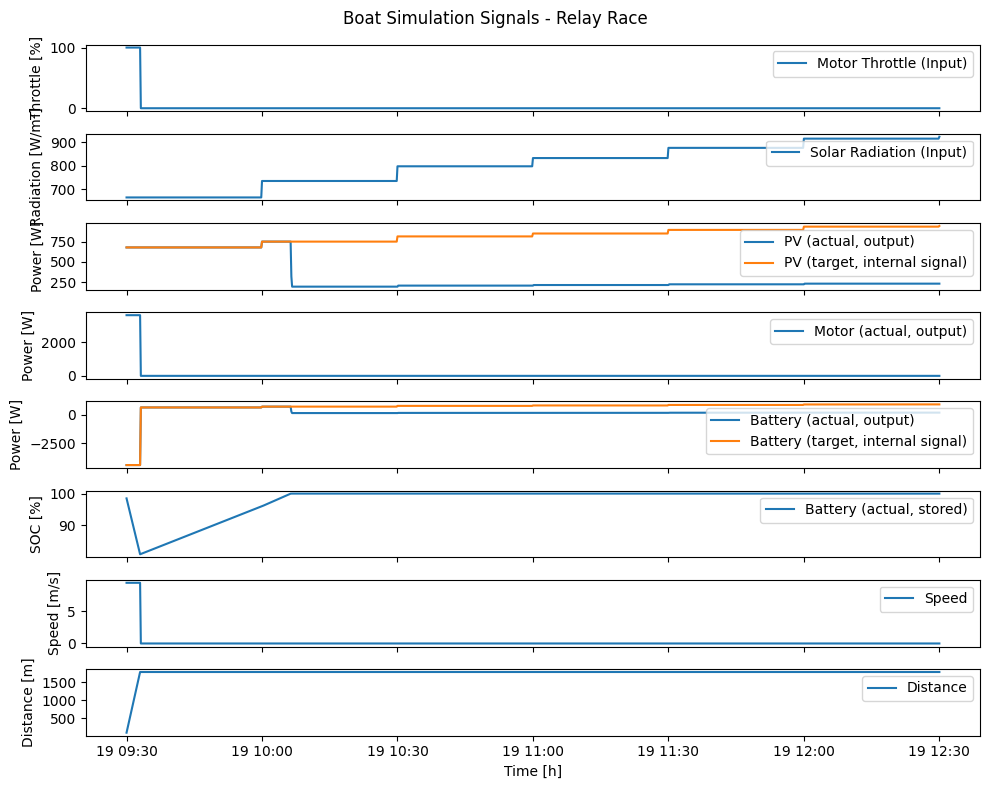

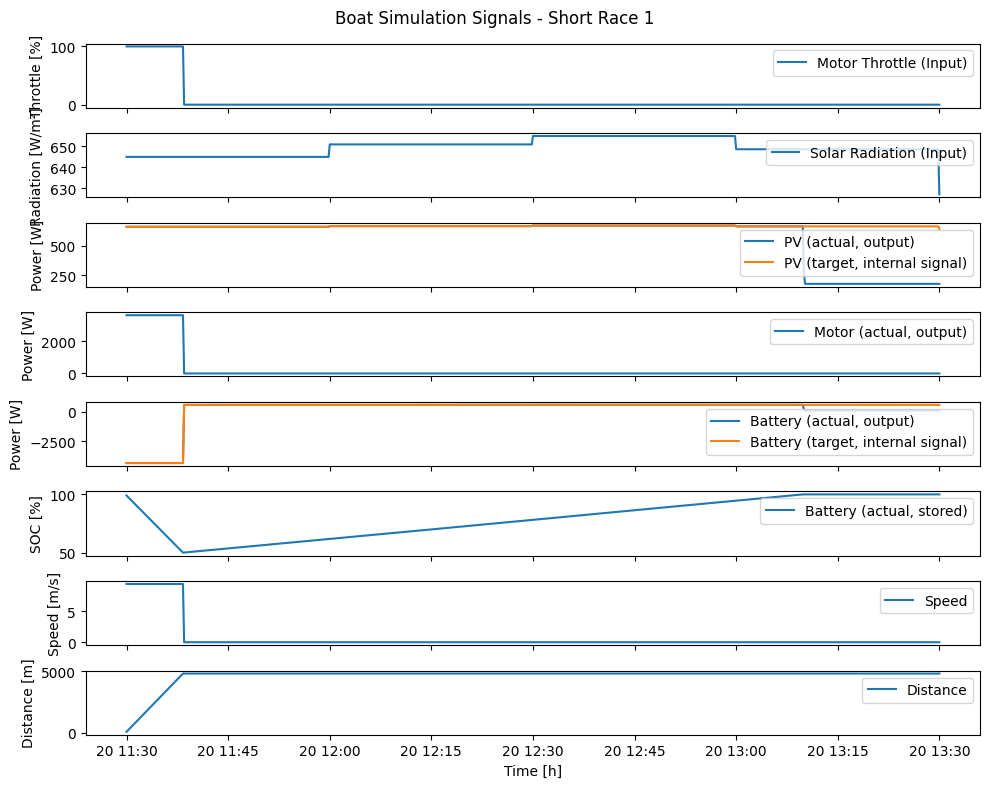

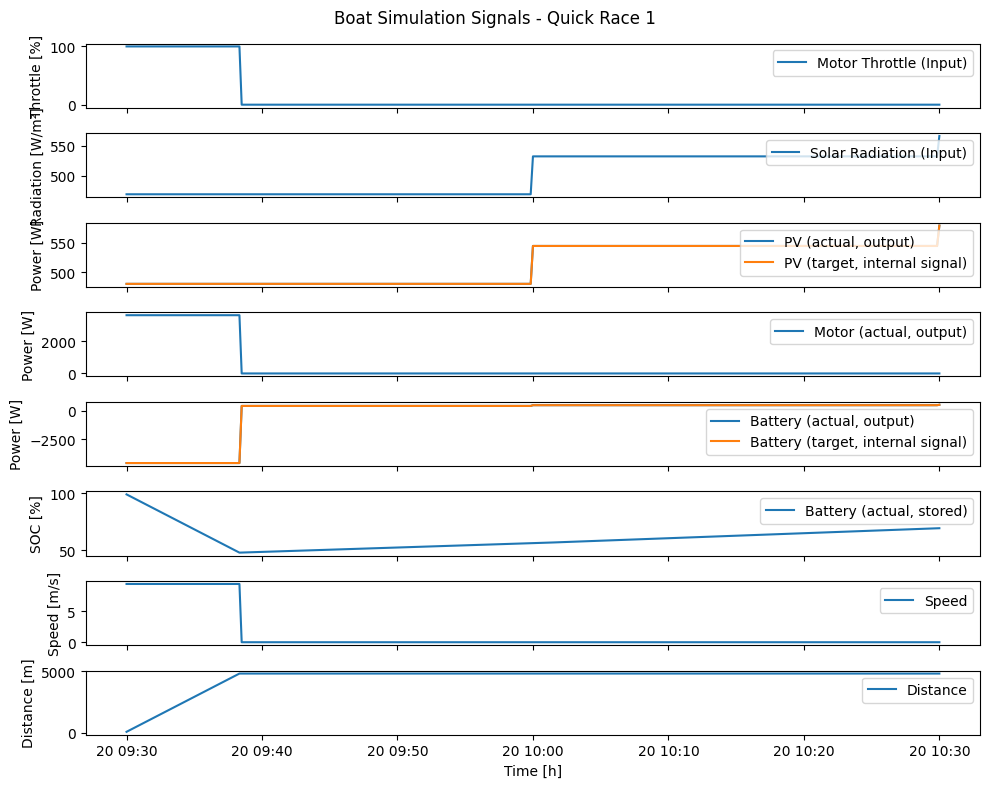

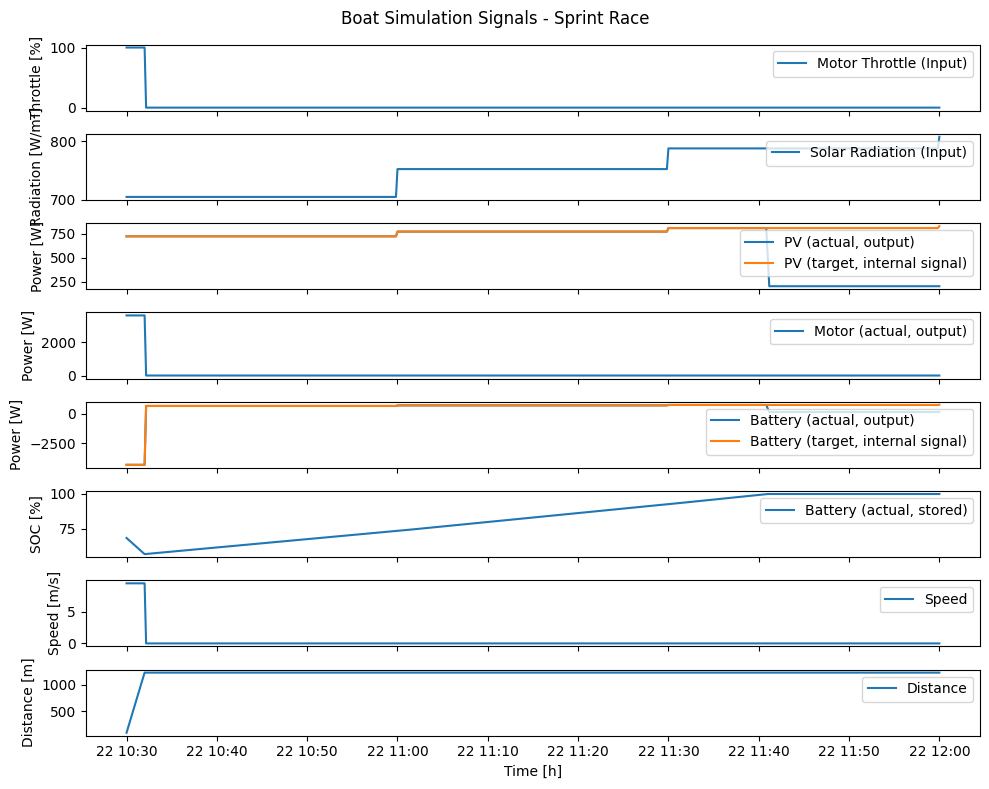

In [21]:
# Plot the simulation

for event_result in competition_result.results:

    fig, axs = plt.subplots(8, figsize=(10, 8 * 1.0), sharex=True, sharey=False)

    for boat_result in event_result:

        result_input_data = boat_result.input_data.to_dataframe().set_index('time').tz_localize('GMT').tz_convert(tzinfo).reset_index(drop=False)
        result_output_data = boat_result.output_data.to_dataframe()

        axs[0].plot(
            result_input_data.time,
            result_output_data.motor_target_throttle * 100,
            label="Motor Throttle (Input)",
        )
        axs[0].legend(loc="upper right")
        axs[0].set_ylabel("Throttle [%]")

        axs[1].plot(
            result_input_data.time,
            result_input_data.poa,
            label="Solar Radiation (Input)",
        )
        axs[1].legend(loc="upper right")
        axs[1].set_ylabel("Radiation [W/m²]")

        axs[2].plot(
            result_input_data.time,
            result_output_data.pv_output_power,
            label="PV (actual, output)",
        )
        axs[2].plot(
            result_input_data.time,
            result_output_data.pv_target_power,
            label="PV (target, internal signal)",
        )
        axs[2].legend(loc="upper right")
        axs[2].set_ylabel("Power [W]")

        axs[3].plot(
            result_input_data.time,
            result_output_data.motor_output_power,
            label="Motor (actual, output)",
        )
        # axs[3].plot(
        #     result_input_data.time,
        #     result_output_data.motor_target_power,
        #     label="Motor (target, internal signal)",
        # )
        axs[3].legend(loc="upper right")
        axs[3].set_ylabel("Power [W]")

        axs[4].plot(
            result_input_data.time,
            result_output_data.battery_output_power,
            label="Battery (actual, output)",
        )
        axs[4].plot(
            result_input_data.time,
            result_output_data.battery_target_power,
            label="Battery (target, internal signal)",
        )
        axs[4].legend(loc="upper right")
        axs[4].set_ylabel("Power [W]")

        axs[5].plot(
            result_input_data.time,
            result_output_data.battery_soc * 100,
            label="Battery (actual, stored)",
        )
        axs[5].legend(loc="upper right")
        axs[5].set_ylabel("SOC [%]")

        axs[6].plot(
            result_input_data.time,
            result_output_data.hull_speed,
            label="Speed",
        )
        axs[6].legend(loc="upper right")
        axs[6].set_ylabel("Speed [m/s]")

        axs[7].plot(
            result_input_data.time,
            boat_result.event_result.distance,
            label="Distance",
        )
        axs[7].legend(loc="upper right")
        axs[7].set_ylabel("Distance [m]")

        plt.xlabel("Time [h]")
        plt.suptitle(f"Boat Simulation Signals - {boat_result.name}")
        plt.tight_layout()

    plt.show()
